In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import re
import json
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [3]:
# Read the data
df = pd.read_csv("Bengaluru_House_Data.csv")
df

,availability,location,size,society,total_sqft,bath,balcony,price
0,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00
...,...,...,...,...,...,...,...,...
13315,Ready To Move,Whitefield,5 Bedroom,ArsiaEx,3453,4.0,0.0,231.00
13316,Ready To Move,Richards Town,4 BHK,NaN,3600,5.0,NaN,400.00
13317,Ready To Move,Raja Rajeshwari Nagar,2 BHK,Mahla T,1141,2.0,1.0,60.00
13318,18-Jun,Padmanabhanagar,4 BHK,SollyCl,4689,4.0,1.0,488.00


In [4]:
df.nunique()

availability      81
location        1305
size              31
society         2688
total_sqft      2117
bath              19
balcony            4
price           1994
dtype: int64

In [5]:
df.dtypes

availability     object
location         object
size             object
society          object
total_sqft       object
bath            float64
balcony         float64
price           float64
dtype: object

In [6]:
# Drop unnecessary columns
df.drop(['society', 'availability', 'balcony'], axis='columns', inplace=True)

In [7]:
df.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [8]:
# Drop rows with missing values
df = df.dropna()
df.reset_index(drop=True, inplace=True)

In [9]:
df['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [10]:
def convert_to_num(x):
    # Check if the input string contains a hyphen ("-")
    if '-' in x:
        tokens = x.split('-')
        if len(tokens) == 2:
            return (float(tokens[0]) + float(tokens[1])) / 2

    # Try using regular expressions to extract the numeric value
    try:
        pattern = r'(\d+(\.\d+)?)'
        matches = re.findall(pattern, x)
        if matches:
            return float(matches[0][0])
    except:
        pass

    # If all else fails, try converting the entire string to a float
    try:
        return float(x)
    except:
        return None

In [11]:
df['total_sqft'] = df['total_sqft'].apply(convert_to_num)
df = df[df['total_sqft'].notnull()]

In [12]:
df['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [13]:
# Extract the value of BHK from the 'size' column
df['bhk'] = df['size'].apply(lambda x: int(x.split(' ')[0]))

In [14]:
# Drop the 'size' column and calculate price per square foot
df.drop(['size'], axis='columns', inplace=True)
df['price_per_sqft'] = df['price'] * 100000 / df['total_sqft']
df

,location,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,51.00,2,4250.000000
...,...,...,...,...,...,...
13241,Whitefield,3453.0,4.0,231.00,5,6689.834926
13242,Richards Town,3600.0,5.0,400.00,4,11111.111111
13243,Raja Rajeshwari Nagar,1141.0,2.0,60.00,2,5258.545136
13244,Padmanabhanagar,4689.0,4.0,488.00,4,10407.336319


In [15]:
# Stripping leading and trailing white spaces from 'location' values for data cleanliness.
df['location'] = df['location'].apply(lambda x: x.strip())
location_stats = df['location'].value_counts(ascending=True)
location_stats

Abshot Layout                        1
Kanakadasa Layout                    1
Kengeri Satellite Town Stage II      1
Kasthuri Nagar East Of NGEF          1
Laxminarayana Layout                 1
                                  ... 
Thanisandra                        236
Kanakpura Road                     266
Electronic City                    304
Sarjapur  Road                     392
Whitefield                         535
Name: location, Length: 1293, dtype: int64

In [16]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

Abshot Layout                       1
Kanakadasa Layout                   1
Kengeri Satellite Town Stage II     1
Kasthuri Nagar East Of NGEF         1
Laxminarayana Layout                1
                                   ..
Gunjur Palya                       10
BTM 1st Stage                      10
Basapura                           10
1st Block Koramangala              10
Ganga Nagar                        10
Name: location, Length: 1052, dtype: int64

In [17]:
df['location'] = df['location'].apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df['location'].unique())

242

In [18]:
# Filtering rows where the ratio of 'total_sqft' to 'bhk' is greater than or equal to 300, ~ is a bitwise operator for NOT
df = df[~(df['total_sqft']/df['bhk']<300)]
df.shape

(12464, 6)

1. The function `remove_pps_outliers` takes a DataFrame df as input.
2. It initializes an empty DataFrame `df_out`.
3. The input DataFrame `df` is grouped by the `'location'` column using `df.groupby('location')`.
4. For each group (`subdf`) obtained from the grouping, it calculates the `mean (m)` and `standard deviation (st)` of the `'price_per_sqft'` column.
5. It creates a new DataFrame called `reduced_df`, which includes rows where `'price_per_sqft'` falls within one standard deviation from the mean (i.e., within the range of `(m-st)` to `(m+st)`).
6. The `reduced_df` is concatenated with the `df_out` DataFrame.
7. The process continues for all location groups, and the final `df_out` DataFrame contains the data without outliers.
8. The function returns the `df_out` DataFrame.

In [19]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf['price_per_sqft'])
        st = np.std(subdf['price_per_sqft'])
        reduced_df = subdf[(subdf['price_per_sqft']>(m-st)) & (subdf['price_per_sqft']<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out

df = remove_pps_outliers(df)
df.shape

(10247, 6)

We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.

1. The function iterates through each `'location'` group in the DataFrame using `df.groupby('location')`.
2. For each `'location'` group, it calculates statistics like `mean`, `standard deviation`, and `count of data points` for each 'bhk' category using another loop that groups by 'bhk'.
3. Then, it goes through the `'bhk'` groups again, and for each 'bhk', it retrieves the statistics for the `'bhk-1'` category (one bedroom less) if it exists and has a count greater than 5.
4. If the statistics for `'bhk-1'` category are available, and there are `atleast 5` data points, it considers those data points as reference values to `identify outliers`.
5. It appends the indices of the data points (rows) that have a `'price_per_sqft'` value lower than the mean value of the `'bhk-1'` category to the exclude_indices array.
6. Finally, the function returns the original DataFrame `df` after dropping the rows with indices present in `exclude_indices`, effectively removing the outliers.

In [20]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df['price_per_sqft']),
                'std': np.std(bhk_df['price_per_sqft']),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df['price_per_sqft']<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')

df = remove_bhk_outliers(df)
df.shape

(7327, 6)

Text(0, 0.5, 'Count')

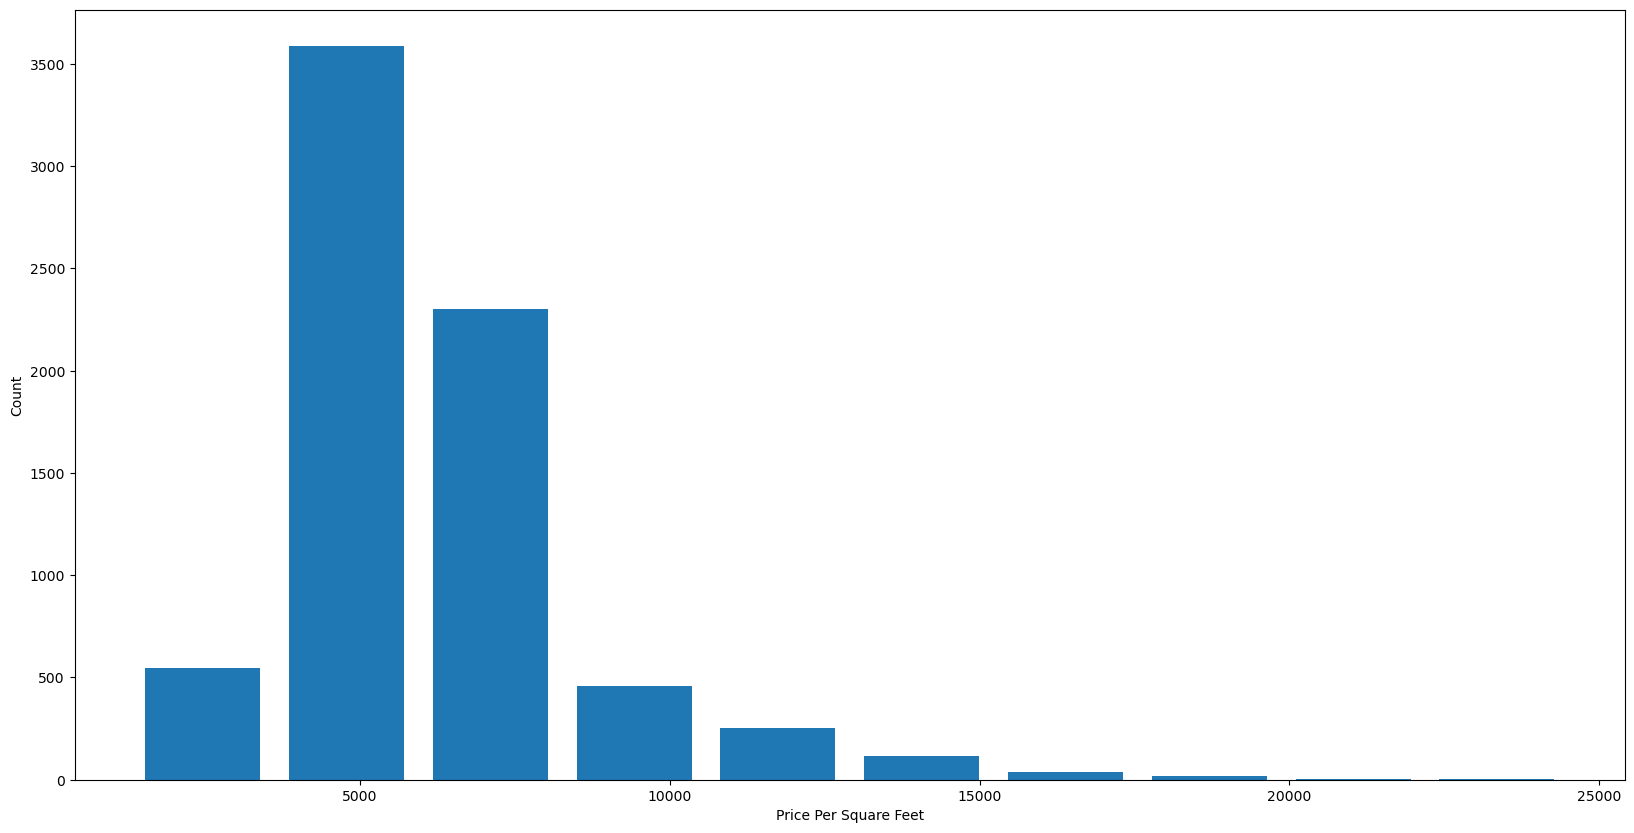

In [21]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

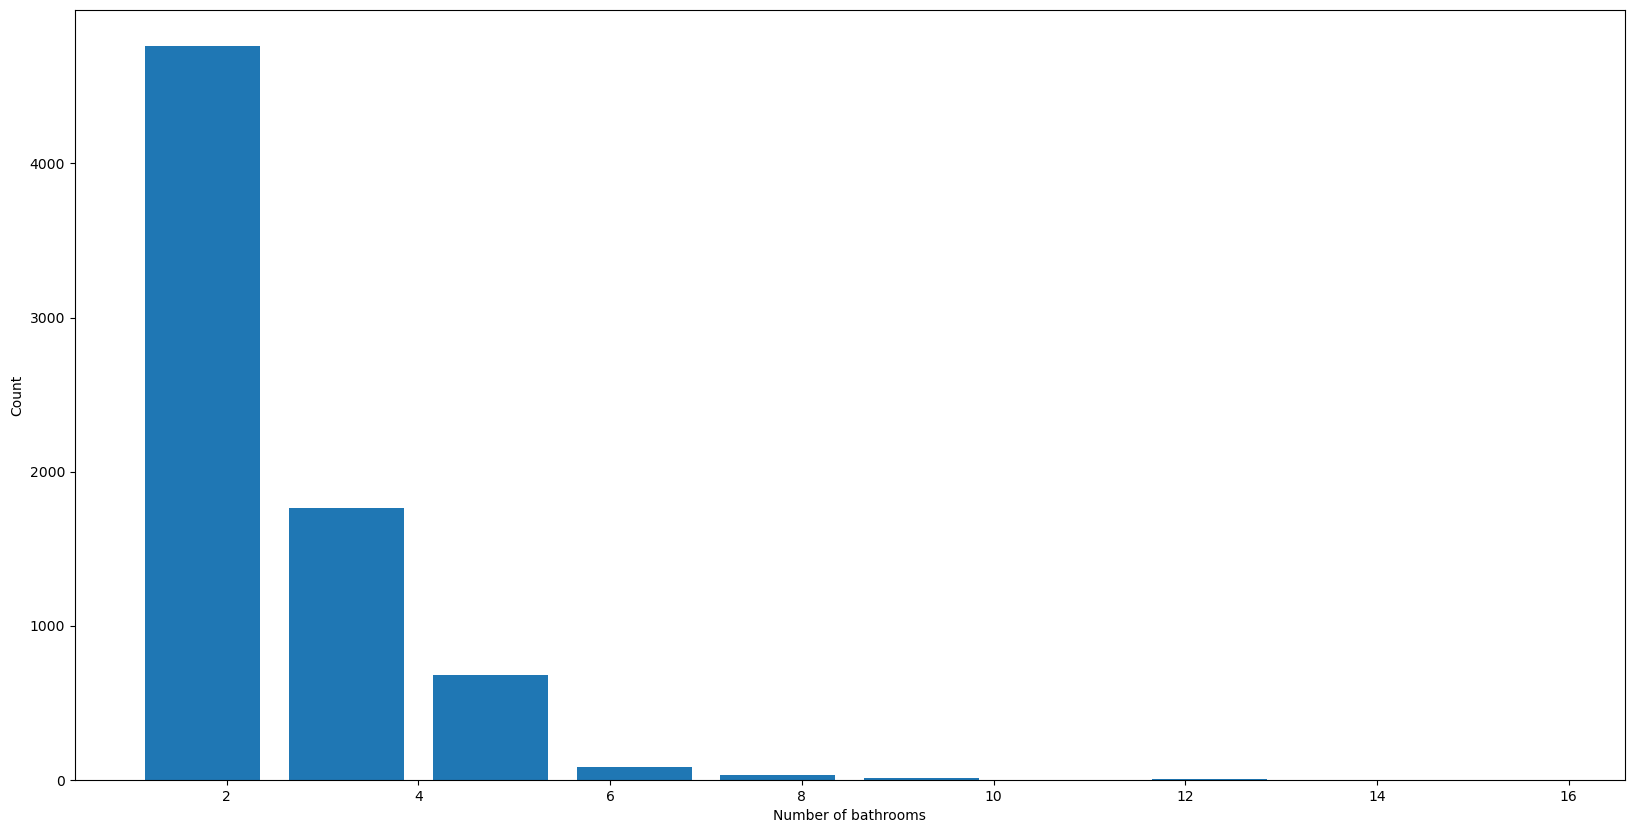

In [22]:
plt.hist(df.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [23]:
df = df[df.bath<df.bhk+2]
df.shape

(7249, 6)

In [24]:
df = df.drop(['price_per_sqft'],axis='columns')
df

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2
...,...,...,...,...,...
10238,other,1200.0,2.0,70.0,2
10239,other,1800.0,1.0,200.0,1
10242,other,1353.0,2.0,110.0,2
10243,other,812.0,1.0,26.0,1


In [25]:
dummies1 = pd.get_dummies(df.location)
dummies1

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10238,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10239,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10242,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10243,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [26]:
df = pd.concat([df,dummies1.drop('other',axis='columns')],axis='columns')
df

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10238,other,1200.0,2.0,70.0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10239,other,1800.0,1.0,200.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10242,other,1353.0,2.0,110.0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10243,other,812.0,1.0,26.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
df = df.drop(['location'],axis='columns')
df.head(2)

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
X = df.drop(['price'],axis='columns')
X.head(3)

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
y = df.price
y.head(3)

0    428.0
1    194.0
2    235.0
Name: price, dtype: float64

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [31]:
def find_best_model_using_gridsearchcv(X, y):
    algos = {
        'linear_regression': {
            'model': LinearRegression(),
            'params': {
                'fit_intercept': [True, False],
                'n_jobs': [1, -1]
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['mse', 'friedman_mse'],
                'splitter': ['best', 'random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X, y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

result_df = find_best_model_using_gridsearchcv(X, y)
result_df

,model,best_score,best_params
0,linear_regression,0.852331,"{'fit_intercept': False, 'n_jobs': 1}"
1,decision_tree,0.771822,"{'criterion': 'friedman_mse', 'splitter': 'ran..."


In [32]:
lr_clf = LinearRegression(fit_intercept=False, n_jobs=1)
lr_clf.fit(X_train, y_train)
score = lr_clf.score(X_test, y_test)
print("Accuracy score:", score)

Accuracy score: 0.8438791475891045


In [33]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.84377644, 0.8519563 , 0.83310272, 0.86189403, 0.86640923])

In [34]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]

In [35]:
predict_price('Uttarahalli',1440,2,3)

66.70032268679088

In [ ]:
import pickle
with open('banglore_home_prices_model.pickle','wb') as f:
    pickle.dump(lr_clf,f)

In [ ]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))